### Predict Sahel rainfall with MLP models - Compute SHAP values

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) data set (https://github.com/MarcoLandtHayen/climate_index_collection). 

Here, we will try to **predict future** Sahel rainfall (lead time 1 month) from current information (t=0) of all **CESM** input features including PREC_SAHEL and **months as additional input features** with **MLP** models:

- Prepare inputs and targets.
- Set up model.
- Evaluate model performance.

**Note:** For an intuitive understanding of SHAP, we refer to the following [video lecture](https://vimeo.com/745352008/3168320cef).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from json import dump, load
from pathlib import Path
import shap

### Import additional functions:
from predict_sahel_rainfall.plot import bar_color
from predict_sahel_rainfall.preprocessing import prepare_inputs_and_target
from predict_sahel_rainfall.models import set_MLP

### Prepare inputs and targets: Univariate

Load collection of climate indices directly from GitHub release.
Use the complete preprocessing pipeline function.

In [2]:
## Set common parameters (except ESN and lead time) for data preprocessing:

# Set url to csv file containing CICMoD indices from desired release:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
)

# Select target index:
target_index = 'PREC_SAHEL'

# Select all input features:
input_features = [
    'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'NAO_PC', 'NAO_ST', 
    'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI',
    'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA', 'SST_ESIO', 'SST_HMDR',
    'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# # Select subset of input features:
# input_features = [
#     'PREC_SAHEL',
# ]

# Choose, whether to add months as one-hot encoded features:
add_months = True

# Choose, whether to normalize target index:
norm_target = True

# Specify input length:
input_length = 1

# Specify amount of combined training and validation data relative to test data:
train_test_split = 0.9

# Specify relative amount of combined training and validation used for training:
train_val_split = 0.8

## Optionally choose to scale or normalize input features according to statistics from training data:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'norm'

In [3]:
# Set parameters for CNN/fc model:
fc_units = [20,10]
fc_activation = 'sigmoid'
output_activation = 'linear'
fc_weight_init = 'glorot_uniform'
fc_bias_init = 'zeros'
fc_weight_reg = None
fc_bias_reg = None
learning_rate = 0.001
loss_function = 'mse'

In [4]:
# Set choice of ESMs:
ESMs = ['CESM']#, 'FOCI']

# Set choice of lead times:
lead_times = [1]#,3,6]

# Set number of runs per setting:
n_runs = 1

# Set number of training epochs:
n_epochs = 50

# Set batch size:
batch_size = 20

# Get number of input features, depending on whether or not months are addes as additional features:
if add_months:
    n_features = len(input_features) + 12
else:
    n_features = len(input_features)
    
# Check number of input channels:
print('Number of input features:',n_features)

Number of input features: 41


In [18]:
## Initializs storages for loss curves and correlation, dimension (#ESMs, #lead times, #runs, #epochs+1).
## Need #epochs+1, since we want to store results for untrained model plus after each epoch.
train_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
train_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    # Get current ESM:
    ESM = ESMs[m]
    
    # Print status:
    print('ESM:',m+1,'of',len(ESMs))

    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Get current lead time:
        lead_time = lead_times[l]
        
        # Print status:
        print('  lead time:',l+1,'of',len(lead_times))

        # Prepare inputs and target for current ESM and lead time:
        (
            train_input,
            train_target,
            val_input,
            val_target,
            test_input,
            test_target,
            train_mean,
            train_std,
            train_min,
            train_max,
        ) = prepare_inputs_and_target(    
            data_url=data_url,
            ESM=ESM,
            target_index=target_index,
            input_features=input_features,
            add_months=add_months,
            norm_target=norm_target,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
            scale_norm=scale_norm,
        )
        
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Print status:
            print('    run:',r+1,'of',n_runs)
            
            # Set up MLP model:
            model = set_MLP(
                input_length=input_length, 
                n_features=n_features, 
                fc_units=fc_units, 
                fc_activation=fc_activation,
                output_activation=output_activation,
                fc_weight_init=fc_weight_init,
                fc_bias_init=fc_bias_init,
                fc_weight_reg=fc_weight_reg,
                fc_bias_reg=fc_bias_reg,
                learning_rate=learning_rate, 
                loss_function=loss_function
            )
            
            ### Train model: Epoch-by-epoch
            
            ## Store results for untrained model:
            
            # Get model predictions on training, validation and test data.
            # Omit time dimension, have only single time step:
            train_pred = model.predict(train_input[:,0,:])
            val_pred = model.predict(val_input[:,0,:])
            test_pred = model.predict(test_input[:,0,:])

            # Compute mse of model predictions vs. true targets:
            train_loss = np.mean((train_target-train_pred)**2)
            val_loss = np.mean((val_target-val_pred)**2)
            test_loss = np.mean((test_target-test_pred)**2)

            # Compute correlation coefficient of model predictions vs. true targets:
            train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
            val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
            test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]
            
            # Store results:
            train_loss_all[m,l,r,0] = train_loss
            val_loss_all[m,l,r,0] = val_loss
            test_loss_all[m,l,r,0] = test_loss
            train_correl_all[m,l,r,0] = train_correl
            val_correl_all[m,l,r,0] = val_correl
            test_correl_all[m,l,r,0] = test_correl          
            
            # Loop over epochs:
            for e in range(n_epochs):
                
                # Train model for single epoch.
                # Omit time dimension, have only single time step:
                history = model.fit(train_input[:,0,:], train_target, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)

                ## Store results after current epoch:
            
                # Get model predictions on training, validation and test data:
                train_pred = model.predict(train_input[:,0,:])
                val_pred = model.predict(val_input[:,0,:])
                test_pred = model.predict(test_input[:,0,:])

                # Compute mse of model predictions vs. true targets:
                train_loss = np.mean((train_target-train_pred)**2)
                val_loss = np.mean((val_target-val_pred)**2)
                test_loss = np.mean((test_target-test_pred)**2)

                # Compute correlation coefficient of model predictions vs. true targets:
                train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                # Store results:
                train_loss_all[m,l,r,e+1] = train_loss
                val_loss_all[m,l,r,e+1] = val_loss
                test_loss_all[m,l,r,e+1] = test_loss
                train_correl_all[m,l,r,e+1] = train_correl
                val_correl_all[m,l,r,e+1] = val_correl
                test_correl_all[m,l,r,e+1] = test_correl          

ESM: 1 of 1
  lead time: 1 of 1
    run: 1 of 1


### Postprocessing

We now have loss ('mse') and correlation for complete training, validation and test data after each epoch (starting with untrained model as epoch 0).

Next, we aim to find the **minimum loss and correlation on test data** for the **epoch with minimum validation loss**.
This search is done separately for each ESM, lead time and model run.

In a second step, we compute the **mean loss and correlation on test data over all runs**, separately for each ESM and lead time.

In [20]:
## Initializs storages for test loss (min) and correlation (max), where val loss takes its minimum,
## dimension (#ESMs, #lead times, #runs).
test_loss_min = np.zeros((len(ESMs),len(lead_times),n_runs))
test_correl_max = np.zeros((len(ESMs),len(lead_times),n_runs))

## Initializs storages for mean test loss and correlation, averaged over all training runs,
## dimension (#ESMs, #lead times).
test_loss_min_mean = np.zeros((len(ESMs),len(lead_times)))
test_correl_max_mean = np.zeros((len(ESMs),len(lead_times)))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Get epoch with minimum validation loss for current ESM, lead time and training run:
            e_min = np.argmin(val_loss_all[m,l,r])
            
            # Store corresponding test loss and correlation:
            test_loss_min[m,l,r] = test_loss_all[m,l,r,e_min]
            test_correl_max[m,l,r] = test_correl_all[m,l,r,e_min]
            
        # Get mean test loss and correlation over all training runs, for current ESM and lead time:
        test_loss_min_mean[m,l] = np.mean(test_loss_min[m,l])
        test_correl_max_mean[m,l] = np.mean(test_correl_max[m,l])

### Results: MLP (with months as additional input features)

In [21]:
test_loss_min_mean

array([[0.92289027]])

In [22]:
test_correl_max_mean

array([[0.40531463]])

### Compute SHAP values

In [26]:
# Create extended input features, including months:
input_features_extended = input_features.copy()
input_features_extended.append('Jan')
input_features_extended.append('Feb')
input_features_extended.append('Mar')
input_features_extended.append('Apr')
input_features_extended.append('May')
input_features_extended.append('Jun')
input_features_extended.append('Jul')
input_features_extended.append('Aug')
input_features_extended.append('Sep')
input_features_extended.append('Oct')
input_features_extended.append('Nov')
input_features_extended.append('Dec')

In [36]:
## Convert inputs and targets into pandas DataFrames.
## Omit time dimension in inputs:

# Inputs:
train_input_pd = pd.DataFrame(train_input[:,0,:], columns = input_features_extended)
val_input_pd = pd.DataFrame(val_input[:,0,:], columns = input_features_extended)
test_input_pd = pd.DataFrame(test_input[:,0,:], columns = input_features_extended)

# Targets:
train_target_pd = pd.DataFrame(train_target, columns = [target_index])
val_target_pd = pd.DataFrame(val_target, columns = [target_index])
test_target_pd = pd.DataFrame(test_target, columns = [target_index])

In [51]:
# Run SHAP framework on trained MLP and use first 1000 training samples as background data.
# Omit time dimension in inputs:
explainer = shap.DeepExplainer(model=model, data=train_input[:1000,0,:])

In [52]:
# Get shap values on test data.
# Omit time dimension in inputs:
shap_values = explainer.shap_values(test_input[:,0,:])[0]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpz1rczzuo.py, line 27)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpz1rczzuo.py, line 27)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


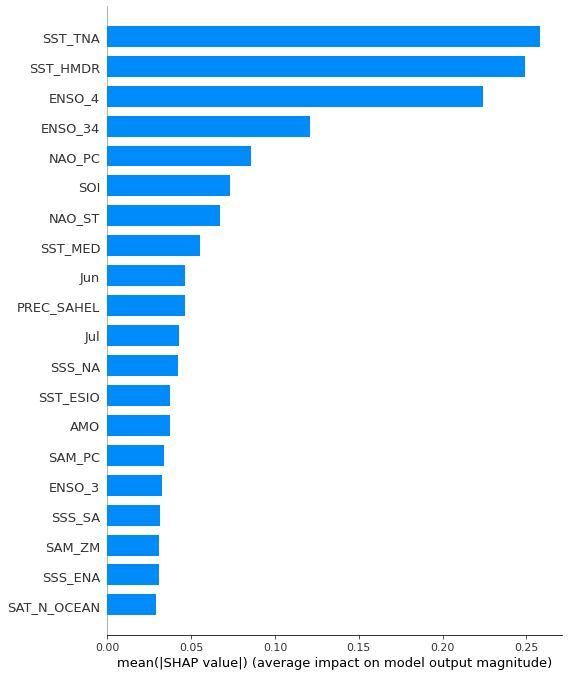

In [54]:
# Summary plot:
shap.summary_plot(
    shap_values, 
    test_input_pd, 
    plot_type='bar')
     

### Discussion: MLP models - multivariate (withmonths as additional input features) - SHAP values

Here, we tried to **predict future** Sahel rainfall (lead time 1 month) from current information (t=0) of all **CESM** input features including PREC_SAHEL and **months as additional input features** with an **MLP** model.

Then, we use SHAPley to compute the average impact of all input features on the model output and find sea surface temperature in the Tropical North Atlantic and the Hurricane Main Developement Region plus ENSO to be most important.